<a href="https://colab.research.google.com/github/ykato27/Speech-Recognition/blob/main/NVidiaWav2LetterPlus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Recognition with Wav2Letter+

This notebook uses [Wav2Letter+](https://arxiv.org/abs/1712.09444) from the open source project [NVIDIA/OpenSeq2Seq](https://github.com/NVIDIA/OpenSeq2Seq.git) to transcribe a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install NVIDIA/OpenSeq2Seq

In [1]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/NVIDIA/OpenSeq2Seq.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q --depth 1 {git_repo_url}
  !git checkout e958b7d
  !pip uninstall -y -q pymc3
  !pip install --upgrade joblib
  #!cd {project_name} && pip install -q -r requirements.txt
  !pip install -q youtube-dl librosa python_speech_features sentencepiece
  
  # create eval config
  !cp {project_name}/example_configs/speech2text/w2lplus_large_8gpus_mp.py {project_name}/conf.py
  !sed -i -e 's/data\/librispeech\/librivox-test-clean/test/' {project_name}/conf.py
  !sed -i -e 's/# "use_lang/"use_lang/' {project_name}/conf.py
  !echo 'backend = "librosa"' >> {project_name}/conf.py 
  #!cat {project_name}/conf.py
  !echo "wav_filename, wav_filesize, transcript" > {project_name}/test.csv
  !echo "test.wav, UNUSED, UNUSED" >> {project_name}/test.csv
  
import sys
sys.path.append(project_name)
from IPython.display import YouTubeVideo

fatal: not a git repository (or any of the parent directories): .git
Requirement already up-to-date: joblib in /usr/local/lib/python3.7/dist-packages (1.0.1)
     |████████████████████████████████| 1.9MB 33.9MB/s 
     |████████████████████████████████| 1.2MB 42.8MB/s 


## Download pre-trained Model

In [2]:
def download_from_google_drive(file_id, file_name):
  # download a file from the Google Drive link
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id={file_id}" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm={confirm_text}&id={file_id}" -o {file_name}
  
if not exists(join(project_name, 'w2l_log_folder')):
  download_from_google_drive('10EYe040qVW6cfygSZz6HwGQDylahQNSa', 'w2l_plus_large.tar')
  !tar xf w2l_plus_large.tar
  !mv w2l_plus_large {project_name}/w2l_log_folder

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   3114      0 --:--:-- --:--:-- --:--:--  3114
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1085M    0 1085M    0     0   206M      0 --:--:--  0:00:05 --:--:--  245M


## Transcribe Youtube Video

We are going to make speech recognition on the following youtube video:

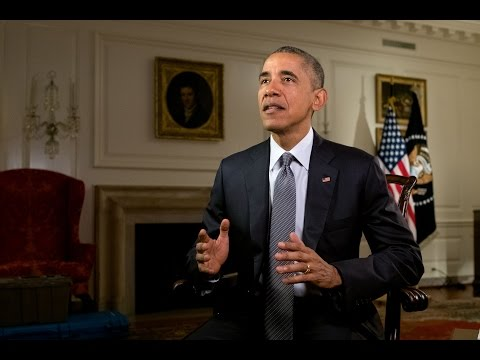

In [3]:
YOUTUBE_ID = '2AFpAATHXtc'


YouTubeVideo(YOUTUBE_ID)

Download the above video, convert to a WAV file and do speech recognition:


In [4]:
!pip uninstall -y tensorflow
!pip install tensorflow==1.15.5

Uninstalling tensorflow-2.5.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.5.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-2.5.0
     |████████████████████████████████| 110.5MB 91kB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 2.9MB 42.5MB/s 
     |████████████████████████████████| 20.1MB 70.1MB/s 
     |████████████████████████████████| 3.8MB 43.2MB/s 
     |████████████████████████████████| 512kB 39.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7557 sha256=ad130694c543ea90ca829b86349667f38f133abbc3660b2738ce1c601a39c2b8
  

In [5]:
!rm -rf *.wav
!youtube-dl --extract-audio --audio-format wav --output "downloaded.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID}
!ffmpeg -loglevel panic -y -i downloaded.wav -acodec pcm_s16le -ac 1 -ar 16000 {project_name}/test.wav
!cd {project_name} && python run.py --config_file conf.py --mode=infer --infer_output_file=output.txt --use_horovod=False --num_gpus=1 --batch_size_per_gpu 1

[youtube] 2AFpAATHXtc: Downloading webpage
[download] Destination: downloaded.m4a
[download] 100% of 2.68MiB in 00:00
[ffmpeg] Correcting container in "downloaded.m4a"
[ffmpeg] Destination: downloaded.wav
Deleting original file downloaded.m4a (pass -k to keep)











The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



*** Restoring from the latest checkpoint
*** Loading model from w2l_log_folder/model.ckpt-109800
*** Inference config:
{'batch_size_per_gpu': 1,
 'data_layer': <class 'open_seq2seq.data.speech2text.speech2text.Speech2TextDataLayer'>,
 'data_layer_params': {'dataset_files': ['test.csv'],
                       'input_type': 'logfbank',
                       'n

Print out the speech recognition result:

In [6]:
!tail -n1 {project_name}/output.txt

test.wav, hieverybody in our house everybody knows that president is only the third most important job in the family so this we get a met to take a lottle extra time to say thank you to michel for the remarkable way she does the most important jout bigama am in a given extra thanks to my mother in law for the roe mal she's always been to michel in the countless selfless ways in which he help was shallin me raise moy ansuch i am incredibly luck to have these wonderful woman help me rays love and look after our cose i hope you' walts't take a moment to so thank you to the woman in your life who love you in that special way monster bylogical mobs the doctive moms and foster mots single moss grandmas godmothers atts mentors whoever you think of when you think a mother's da or take a moment like our walter remember the mobs who raised us whis big hearts sustained us and whom we mess every day no matter howld we get giving flowers is always a good idea but i hope that on this mother's day wi